In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

from dataprep import transform_indices
from polara.preprocessing.dataframes import reindex, leave_one_out

2023-03-29 13:21:51.966421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 13:21:52.178982: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-29 13:21:52.848981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-29 13:21:52.849066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

In [2]:
data = pd.read_csv('training.csv')
data = data.dropna()
data

,userid,movieid,rating,timestamp
0,158862,1600.0,4.0,9.783073e+08
1,49693,9102.0,4.0,9.854663e+08
2,65237,2408.0,3.0,9.783080e+08
3,82765,2590.0,2.0,9.851394e+08
4,120946,285.0,2.0,9.783085e+08
...,...,...,...,...
6371801,153374,5422.0,4.0,1.078628e+09
6371802,153374,1958.0,2.5,1.075267e+09
6371803,153374,1959.0,2.5,1.075267e+09
6371804,153374,385.0,3.0,1.078625e+09


In [3]:
df = data.sort_values(['userid', 'timestamp'], ascending=[True, True]).reset_index()
user_avg_rating = df.groupby(df.userid)['rating'].expanding().mean().reset_index()
user_std_rating = df.groupby(df.userid)['rating'].expanding().std().reset_index()
user_rating_count = df.groupby(df.userid)['rating'].expanding().count().reset_index()

df['user_avg_rating'] = user_avg_rating['rating']
df['user_std_rating'] = user_std_rating['rating'].fillna(0)
df['user_rating_count'] = user_rating_count['rating']

In [4]:
data = df.copy()
data.head()

,index,userid,movieid,rating,timestamp,user_avg_rating,user_std_rating,user_rating_count
0,5249,0,14.0,2.0,1.256677e+09,2.000000,0.000000,1.0
1,5235,0,0.0,3.5,1.256677e+09,2.750000,1.060660,2.0
2,5240,0,5.0,2.5,1.256677e+09,2.666667,0.763763,3.0
3,5243,0,8.0,4.0,1.256677e+09,3.000000,0.912871,4.0
4,5248,0,13.0,3.5,1.256677e+09,3.100000,0.821584,5.0


In [5]:
y = data['rating'].astype('float32')

In [6]:
# source code from seminar

test_timepoint = data['timestamp'].quantile(q=0.80, interpolation='nearest')

test_data_ = data.query('timestamp >= @test_timepoint')
train_data_ = data.query('userid not in @test_data_.userid.unique() and timestamp < @test_timepoint')

train_data, data_index = transform_indices(train_data_.copy(), 'userid', 'movieid')
test_data = reindex(test_data_, data_index['items'])

Filtered 107673 invalid observations.


In [7]:
testset_, holdout_ = leave_one_out(
    test_data, target='timestamp', sample_top=True, random_state=0
)
testset_valid_, holdout_valid_ = leave_one_out(
    testset_, target='timestamp', sample_top=True, random_state=0
)

In [8]:
userid = data_index['users'].name
test_users = pd.Index(
    # ensure test users are the same across testing data
    np.intersect1d(
        testset_valid_[userid].unique(),
        holdout_valid_[userid].unique()
    )
)
testset_valid = (
    testset_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)
holdout_valid = (
    holdout_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)

In [9]:
raw_train = train_data.reset_index(drop=True)
raw_val = testset_valid.reset_index(drop=True)
raw_test = holdout_valid.reset_index(drop=True)

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((dict(raw_train), y.iloc[raw_train.index])).shuffle(len(raw_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((dict(raw_val), y.iloc[raw_val.index])).shuffle(len(raw_val)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((dict(raw_test), y.iloc[raw_test.index])).shuffle(len(raw_test)).batch(32)

2023-03-29 13:22:16.005328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-29 13:22:16.005377: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-29 13:22:16.005416: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2023-03-29 13:22:16.005926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
inputs = {
          'movieid' : tf.keras.layers.Input(name='movieid', shape=(), dtype = 'int32'),
          'userid': tf.keras.layers.Input(name='userid', shape=(), dtype='int32'),
          'user_avg_rating': tf.keras.layers.Input(name='user_avg_rating', shape=(), dtype='float32'),
          'user_std_rating': tf.keras.layers.Input(name='user_std_rating', shape=(), dtype='float32'),
          'user_rating_count': tf.keras.layers.Input(name='user_rating_count', shape=(), dtype='int32')
}

In [12]:
data.movieid.max(), data.userid.max()

(48118.0, 283222)

In [13]:
movie_col = tf.feature_column.categorical_column_with_identity(key='movieid', num_buckets=48119)         
movie_emb_col = tf.feature_column.embedding_column(movie_col, 10)
movie_ind_col = tf.feature_column.indicator_column(movie_col)

user_col = tf.feature_column.categorical_column_with_identity(key='userid', num_buckets=283223)
user_emb_col = tf.feature_column.embedding_column(user_col, 10)
user_ind_col = tf.feature_column.indicator_column(user_col)

categorical_columns = [movie_emb_col, user_emb_col]

In [14]:
user_avg_rating_col = tf.feature_column.numeric_column('user_avg_rating')
user_std_rating_col = tf.feature_column.numeric_column('user_std_rating')
user_rating_count_col = tf.feature_column.numeric_column('user_rating_count')

numerical_columns = [user_avg_rating_col , user_std_rating_col , user_rating_count_col]

Reference: 

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [15]:
# Define plot and early stopping as the same as neuralCF

def plot(history):
    cross_entropy_train = history.history['loss']
    cross_entropy_val = history.history['val_loss']

    epochs = range(len(cross_entropy_train))

    plt.title('Training and validation cross entropy')
    plt.plot(epochs, cross_entropy_train, color='blue', label='Train')
    plt.plot(epochs, cross_entropy_val, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Cross entropy')
    plt.legend()

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=8,
    mode='auto',
    restore_best_weights=True)

#### DeepFM


Reference:

https://towardsdatascience.com/a-performant-recommender-system-without-cold-start-problem-69bf2f0f0b9b

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/migrate/migrating_feature_columns.ipynb?hl=da#scrollTo=JsoYUUgRS7hu

https://towardsdatascience.com/how-to-build-a-wide-and-deep-model-using-keras-in-tensorflow-2-0-2f7a236b5a4b

https://keras.io/api/models/model_training_apis/

In [17]:
first_order_cols = [movie_ind_col, user_ind_col]
first_order_layer = tf.keras.layers.DenseFeatures(first_order_cols)(inputs)

movie_emb_layer = tf.keras.layers.DenseFeatures([movie_emb_col])(inputs)
user_emb_layer = tf.keras.layers.DenseFeatures([user_emb_col])(inputs)
product_layer_movie_user = tf.keras.layers.Dot(axes=1)([movie_emb_layer, user_emb_layer])

deepfm_deep = tf.keras.layers.DenseFeatures(numerical_columns+categorical_columns)(inputs)
deepfm_deep = tf.keras.layers.Dense(256, activation='relu')(deepfm_deep)
deepfm_deep = tf.keras.layers.Dense(128, activation='relu')(deepfm_deep)

deepfm_concat_layer = tf.keras.layers.concatenate([first_order_layer, 
                                                   product_layer_movie_user, 
                                                   deepfm_deep
                                                   ], axis=1)

deepfm_output_layer = tf.keras.layers.Dense(1)(deepfm_concat_layer)
deepfm_model = tf.keras.Model(inputs, deepfm_output_layer)

In [19]:
deepfm_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam'
)

deepfm_history = deepfm_model.fit(train_ds,
                validation_data = val_ds, 
                callbacks=[early_stopping],
                epochs=3)

Epoch 1/3


2023-03-28 19:25:58.520369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2298086 of 4427415


     2/138357 [..............................] - ETA: 2:40:13 - loss: -968342387032064.0000   

2023-03-28 19:26:07.617757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


138357/138357 [==============================] - 9011s 65ms/step - loss: -2551003341651968.0000 - val_loss: -3675378535104512.0000
Epoch 2/3


2023-03-28 21:56:17.005075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 850964 of 4427415
2023-03-28 21:56:18.574765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 859160 of 4427415
2023-03-28 21:56:28.551504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2936316 of 4427415
2023-03-28 21:56:38.551738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3169679 of 4427415


     2/138357 [..............................] - ETA: 3:00:11 - loss: -4522829806567424.0000   

2023-03-28 21:56:45.752603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


138357/138357 [==============================] - ETA: 0s - loss: -8115218836094976.0000

2023-03-29 00:18:40.012012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1074098 of 1121741
2023-03-29 00:18:40.275520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


138357/138357 [==============================] - 9339s 67ms/step - loss: -8115218836094976.0000 - val_loss: -10254879738036224.0000
Epoch 3/3


2023-03-29 00:31:48.000626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2622291 of 4427415
2023-03-29 00:31:58.000610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3751725 of 4427415


     3/138357 [..............................] - ETA: 2:49:48 - loss: -13401049582796800.0000 

2023-03-29 00:32:01.444823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


138357/138357 [==============================] - 9192s 66ms/step - loss: -19902038783557632.0000 - val_loss: -23138863576776704.0000


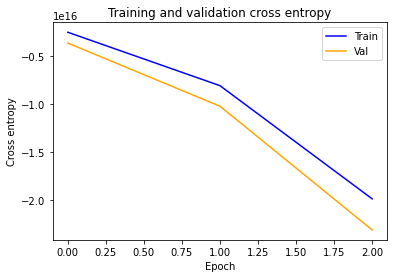

In [18]:
plot(deepfm_history)

In [20]:
deepfm_model.save('deepfm_2_crossE', include_optimizer = False)

INFO:tensorflow:Assets written to: deepfm_2_crossE/assets
